# About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).


## Imports and Installations

In [ ]:
import random

# Set a seed for the random number generator
random.seed(42)  # You can choose any integer as the seed

In [ ]:

!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
import random
filterwarnings('ignore')


# DATASET

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("./Dataset/diabetes.csv")
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# DATA PRE-PROCESSING

In [ ]:
# Let's make variables's names smaller

df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

   Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
   Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables

        The sum of 3 lists with return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [ ]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
# Outliers

def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit



In [ ]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

    for col in df.columns:
        print(col, grab_outliers(df,col))

In [ ]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None
None
None
None
None
None
None
None


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.842,3.360,0.000,1.000,3.000,6.000,15.000
glucose,768.000,120.937,31.816,6.500,99.000,117.000,140.250,199.000
bloodpressure,768.000,70.188,15.673,24.200,62.000,72.000,80.000,110.000
skinthickness,768.000,20.504,15.817,0.000,0.000,23.000,32.000,74.000
insulin,768.000,75.132,97.656,0.000,0.000,30.500,127.250,359.800
bmi,768.000,32.047,7.454,5.968,27.300,32.000,36.600,53.785
diabetespedigreefunction,768.000,0.463,0.296,0.078,0.244,0.372,0.626,1.321
age,768.000,33.224,11.700,21.000,24.000,29.000,41.000,70.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [ ]:
# There are no missing observations in the dataset
# but for variables such as Glucose, Insulin, etc., observation units containing a value of 0 may represent a missing value.

variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                     374
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [ ]:
# Handle to missing value
# df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                       0
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

## Feature Engineering
future engineering is crucial for machine learning because it allows for the development of more advanced and efficient models that can handle larger and more complex datasets.

Machine learning is a rapidly evolving field, and new techniques and algorithms are being developed at an ever-increasing pace. Future engineering is essential for keeping up with these advances, as it involves developing new hardware and software technologies that can support more advanced machine learning models.

Future engineering also involves the development of software frameworks and libraries that can facilitate the development and deployment of machine learning models. For instance, Tensorflow and PyTorch are two widely used frameworks that provide a high-level interface for building and training machine learning models, making it easier for researchers and developers to create and deploy models.

Moreover, future engineering can help address some of the challenges facing machine learning, such as the need for more efficient algorithms and the ethical considerations surrounding AI. By developing new tools and techniques, we can better understand and control the behavior of machine learning models, leading to more reliable and trustworthy systems.

In summary, future engineering is essential for advancing machine learning, and it will play a critical role in shaping the future of AI.

In [ ]:
df = df[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction','outcome']]

In [ ]:
num_cols.remove('pregnancies')
num_cols.remove('skinthickness')
num_cols.remove('age')

In [ ]:
# Now time to future scaling for numeric cols

rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])
df.head()


,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,0.752,0.000,0.946,0.172,0.665,1
1,-0.776,-0.333,0.000,-0.581,-0.056,0
2,1.600,-0.444,0.946,-0.935,0.783,1
3,-0.679,-0.333,-0.457,-0.419,-0.537,0
4,0.485,-1.778,0.628,1.194,2.480,1


# **Testing inverse scaler**

In [ ]:
newdf = df.copy()
newdf[num_cols] = rs.inverse_transform(df[num_cols])

In [ ]:
newdf.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,148.000,72.000,189.692,33.600,0.627,1
1,85.000,66.000,125.155,26.600,0.351,0
2,183.000,64.000,189.692,23.300,0.672,1
3,89.000,66.000,94.000,28.100,0.167,0
4,137.000,40.000,168.000,43.100,1.321,1


## PREDICTION

### Light GBM

In [ ]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)


lgbm = LGBMClassifier(learning_rate=0.01, max_depth=3, subsample=0.6, n_estimators=1000, min_child_samples=10)
lgbm_model = lgbm.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.8701298701298701

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        99
           1       0.83      0.80      0.81        55

    accuracy                           0.87       154
   macro avg       0.86      0.85      0.86       154
weighted avg       0.87      0.87      0.87       154



In [ ]:
# explainer = shap.TreeExplainer(model, data=X_train)
# shap_values = explainer.shap_values(X_test, check_additivity=False)


## Getting SHAPley Values

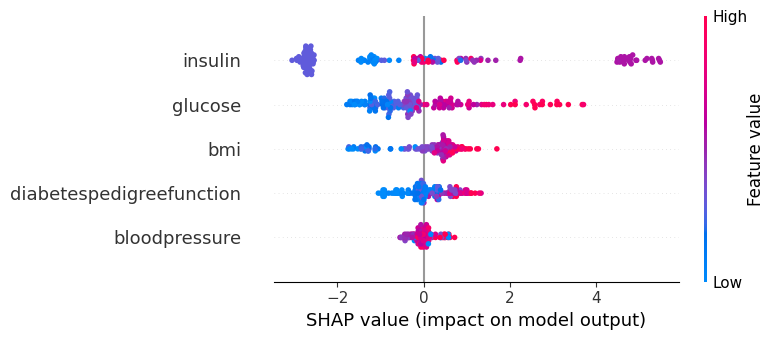

In [ ]:
import shap
explainer = shap.TreeExplainer(lgbm_model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Create a summary plot for feature importance across all predictions
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
X_test_ID = X_test.copy()
X_test_ID['ID'] = [i for i in range(1, len(X_test)+1)]

In [ ]:
#shap_values = explainer(X_test)

# Create a DataFrame with SHAP values and 'ID' as a separate column
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

shap_df['ID'] = list(X_test_ID['ID'])
class_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
predicted_labels = lgbm_model.predict(X_test)
shap_df['prediction'] = predicted_labels
shap_df['class_prob'] = class_probabilities

In [ ]:
shap_df.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,ID,prediction,class_prob
0,-0.775,-0.533,2.252,0.557,-0.002,1,0,0.441
1,-0.403,0.026,-2.698,0.462,-0.925,2,0,0.005
2,-0.397,0.005,-2.778,0.243,-0.941,3,0,0.004
3,-0.184,0.063,-2.717,-1.361,1.004,4,0,0.007
4,0.798,0.507,-2.797,0.323,0.057,5,0,0.055


In [ ]:
X_test['outcome'] = y_test
X_test_n = X_test.copy()
X_test_n[num_cols] = rs.inverse_transform(X_test[num_cols])

In [ ]:
X_test_n['ID'] = [i for i in range(1, len(X_test)+1)]

In [ ]:
# Set a fixed seed for reproducibility
random_state = 42

# Separate examples by class
class_0_examples = X_test_n[X_test_n['outcome'] == 0]
class_1_examples = X_test_n[X_test_n['outcome'] == 1]

# Select 13 examples labeled as '1' and 12 examples labeled as '0'
X_test_llm = pd.concat([class_0_examples.sample(12, random_state=random_state),
                        class_1_examples.sample(13, random_state=random_state)])

# The random_state parameter ensures consistent sampling


In [ ]:
shap_df_llm = shap_df[shap_df['ID'].isin(X_test_llm['ID'])]

In [ ]:
num_cols

['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']

## Prompt Engineering and Automating Prompt Generation

In [ ]:
def getPrompts():
  prompt1 = """Hey buddy,
We want to use natural text to query a machine-learning medical model directly, bridging the gap between complex algorithmic processes and patient comprehensibility.
We have trained a machine learning model to predict the likelihood of the person getting diagnosed with diabetes when given a patient's vital feature data.
Given the feature list and the corresponding SHAP values for that patient, I want you to translate a simple, human-understandable explanation of how the model works, and, in case of the question request lifestyle suggestion, I want you to suggest changes to the two most important features to increase the likelihood of the person surviving.


Here is the feature list:
['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']

Here is the model prediction probability (0: No Diabetes, 1: Diabetes): """

  # prob = 0.1 # fill actual values

  prompt2 = """\n\nHere are this test subjects corresponding feature values: """

  # feature_values = [21,4,3,425,43,2]

  prompt3 = """\n\nAnd here are the corresponding SHAP values for that particular patient/record in the test set: """

  # shap_values = [2332,342,4,36,3,654,76,47]

  prompt4 = """\n\nThe Question:\n"""

  # ques = "what can I as a patient focus on to reduce my risk rate?"

  prompt5="\n\nYour Answer in no more than 250 words :\n"

  prompt6="\nYou are trying to explain it to a patient who does not have a machine learning experience and what SHAP values mean.\n"

  return prompt1, prompt2, prompt3, prompt4, prompt5,prompt6

In [ ]:
def generate_final_prompt(prob, features_values, shap_values, ques):

    prompt1, prompt2, prompt3, prompt4, prompt5, prompt6 = getPrompts()
    prompt = prompt1 + str(prob) + prompt2 + str(features_values) + prompt3 + str(shap_values) + prompt4 + str(ques) + prompt5 + prompt6

    return prompt

In [ ]:
question_list_high_risk = ["Why is the risk score so high?","What could be done to lower the risk score?","How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', 'diabetespedigreefunction') affect this risk score?"]

In [ ]:
question_list_low_risk = ["What factors contributed to my low risk of diabetes?","Are there specific lifestyle changes I can make to maintain this low risk?","How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', 'diabetespedigreefunction') affect this risk score?"]

## Generate the prompts dataframe

In [ ]:
prompt_entries = []
for index, row in shap_df_llm.iterrows():
  shap_values = list(row[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])
  features= X_test_llm[X_test_llm['ID'] == row['ID']].iloc[0]
  features_values = list(features[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])
  pred = row['class_prob']
  if pred>=0.5:
    question_list = question_list_high_risk
  else:
    question_list = question_list_low_risk
  for ques in question_list:
    prompt = generate_final_prompt(pred,features_values,shap_values,ques)
    prompt_entries.append([row['ID'], prompt])

In [ ]:
df_prompts = pd.DataFrame(prompt_entries, columns=['ID', 'Prompt'])

In [ ]:
df_prompts

,ID,Prompt
0,1.000,"Hey buddy,\nWe want to use natural text to que..."
1,1.000,"Hey buddy,\nWe want to use natural text to que..."
2,1.000,"Hey buddy,\nWe want to use natural text to que..."
3,12.000,"Hey buddy,\nWe want to use natural text to que..."
4,12.000,"Hey buddy,\nWe want to use natural text to que..."
5,12.000,"Hey buddy,\nWe want to use natural text to que..."
6,19.000,"Hey buddy,\nWe want to use natural text to que..."
7,19.000,"Hey buddy,\nWe want to use natural text to que..."
8,19.000,"Hey buddy,\nWe want to use natural text to que..."
9,24.000,"Hey buddy,\nWe want to use natural text to que..."
